In [15]:
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

# Ignore the warning message
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
infile = open("preprocessed_fairness_data.pkl", "rb")
df = pickle.load(infile)
infile.close()

Build subgroups

In [8]:
# Abi eltern
df.AbiEltern = df.AbiEltern.astype("float")
df_abi = df[df.AbiEltern > 0]
df_keinAbi = df[df.AbiEltern == 0]
df_weissnicht = df[df.AbiEltern.isnull()]

print(len(df_abi.UserID_y.unique()))
print(len(df_keinAbi.UserID_y.unique()))
print(len(df_weissnicht.UserID_y.unique()))

1206
464
1079


In [9]:
# Gender
df_boys = df[df.Sex__m == 1]
df_girls = df[df.Sex__w == 1]
print(len(df_boys.UserID_y.unique()))
print(len(df_girls.UserID_y.unique()))

1339
1325


In [10]:
# Migration
df_deutsch = df[df.eigSprache == 1]
df_migration = df[df.eigSprache == 0]

print(len(df_deutsch.UserID_y.unique()))
print(len(df_migration.UserID_y.unique()))

1683
1066


In [11]:
# Anzahl Bücher
df["Buecher"] = df["Buecher"].replace(["10"], 0)
df["Buecher"] = df["Buecher"].replace(["200"], 1)
df_buch0 = df[df.Buecher == 0.0]
df_buch1 = df[df.Buecher == 1]

print(len(df_buch0.UserID_y.unique()))
print(len(df_buch1.UserID_y.unique()))

149
1092


Build matrices for each subgroup and t

In [12]:
df_name = [
    df_abi,
    df_keinAbi,
    df_boys,
    df_girls,
    df_deutsch,
    df_migration,
    df_buch0,
    df_buch1,
]
matrice = [
    "matrices_forte_abi",
    "matrices_forte_keinAbi",
    "matrices_forte_boys",
    "matrices_forte_girls",
    "matrices_forte_deutsch",
    "matrices_forte_migration",
    "matrices_buecher_0",
    "matrices_buecher_1",
]


for df_name, matrice in zip(df_name, matrice):
    df_1 = df_name.loc[df_name["OrderNumber"] == 1]
    matrix1_path = matrice + "/matrix1.pkl"
    df_1.to_pickle(matrix1_path)

    n = list(range(2, 61))
    
    for x in n:
        df_x = df_name.loc[df_name["OrderNumber"] < (x + 1)]
        df_x = df_x.groupby("UebungsID").agg(
            {
                "ID": "count",
                "Erstloesung": "sum",
                "Schussel": "sum",
                "Erfolg": "sum",
                "Schwierigkeit": "mean",
                "ist_Schulzeit": "first",
                "MehrfachFalsch": "first",
                "vorher_abgebrochen": "first",
                "y": "first",
                "UserAttribut": "first",
                "Fehler": "first",
                "Klassenstufe": "first",
                "Jahredabei": "first",
                "AnzahlAufgaben": "first",
                "Art__GK": "first",
                "Art__GR": "first",
                "Art__GZ": "first",
                "Art__K": "first",
                "Art__LB": "first",
                "HA__HA": "first",
                "HA__Self": "first",
                "HA__nt": "first",
                "HA__vt": "first",
                "HA__zt": "first",
                "Sex__m": "first",
                "Sex__w": "first",
                "Testposition__pruefung": "sum",
                "Testposition__training": "sum",
                "Testposition__version": "sum",
                "OrderNumber": "max",
                "steps": "max",
            }
        )

        df_x = df_x.loc[df_x["ID"] == x]
        path = matrice + "/matrix" + str(x) + ".pkl"
        df_x.to_pickle(path)

Get count per subgroup and t

In [17]:
group = [
    "abiEltern",
    "abiEltern",
    "gender",
    "gender",
    "erstsprache",
    "erstsprache",
    "buecher",
    "buecher",
]
subgroup = ["abi", "keinAbi", "boys", "girls", "deutsch", "migration", "buch0", "buch1"]
df_name = [
    df_abi,
    df_keinAbi,
    df_boys,
    df_girls,
    df_deutsch,
    df_migration,
    df_buch0,
    df_buch1,
]
sentence_len = pd.DataFrame(columns=["Sentence", "Count", "group", "subgroup"])
matrice = [
    "matrices_forte_abi",
    "matrices_forte_keinAbi",
    "matrices_forte_boys",
    "matrices_forte_girls",
    "matrices_forte_deutsch",
    "matrices_forte_migration",
    "matrices_forte_buecher_0",
    "matrices_forte_buecher_1",
]

for df_name, group, subgroup, matrice in zip(df_name, group, subgroup, matrice):
    n = list(range(2, 61))
    
    for x in n:
        path = matrice + "/matrix" + str(x) + ".pkl"
        infile = open(path, "rb")
        get_length = pickle.load(infile)
        l = len(get_length)
        sentence_len = sentence_len.append(
            {"Sentence": x, "Count": l, "group": group, "subgroup": subgroup},
            ignore_index=True,
        )

    sentence_len["Sentence"] = sentence_len["Sentence"].astype("int")
    sentence_len["Count"] = sentence_len["Count"].astype("int")

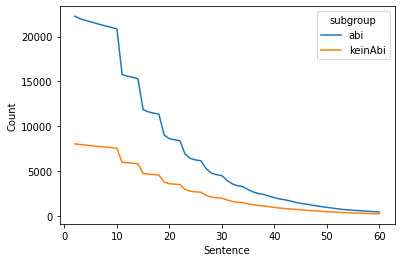

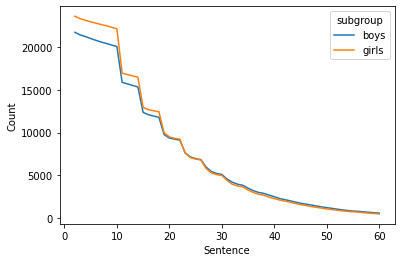

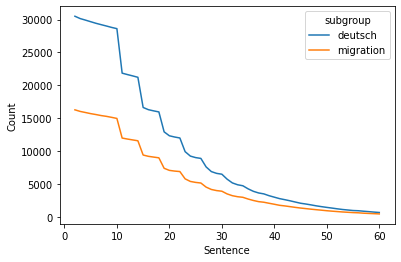

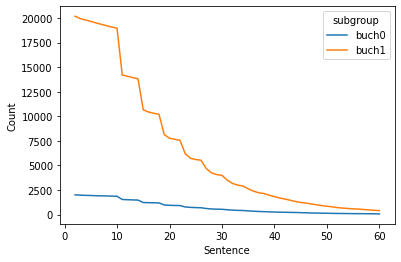

In [18]:
group = ["abiEltern", "gender", "erstsprache", "buecher"]

for x in group:
    df = sentence_len[sentence_len.group == x]
    sns.lineplot(data=df, x="Sentence", y="Count", hue="subgroup")
    plt.show()

Count of users per subgroup

In [28]:
subgroup = [
    df_abi,
    df_keinAbi,
    df_boys,
    df_girls,
    df_deutsch,
    df_migration,
    df_buch0,
    df_buch1,
]

for x in subgroup:
    x = x[["UserID_y", "y", "UebungsID"]]
    x = x.drop_duplicates()
    g = x.groupby("y").count()
    print(g.UebungsID)

y
0     3224
1    19597
Name: UebungsID, dtype: int64
y
0    1167
1    7064
Name: UebungsID, dtype: int64
y
0     4024
1    18447
Name: UebungsID, dtype: int64
y
0     3349
1    20801
Name: UebungsID, dtype: int64
y
0     4349
1    26901
Name: UebungsID, dtype: int64
y
0     3179
1    13677
Name: UebungsID, dtype: int64
y
0     406
1    1653
Name: UebungsID, dtype: int64
y
0     2756
1    17955
Name: UebungsID, dtype: int64


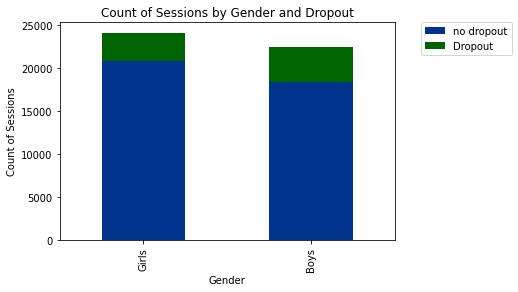

In [ ]:
data = {"Dropout": [3349, 4024], "no dropout": [20801, 18447]}

df = pd.DataFrame(data, columns=["no dropout", "Dropout"], index=["Girls", "Boys"])

ax = df.plot(kind="bar", stacked=True, color=["#00338d", "darkgreen"])
# Add Title and Labels
plt.title("Count of Sessions by Gender and Dropout")
plt.xlabel("Gender")
plt.ylabel("Count of Sessions")
plt.legend(bbox_to_anchor=(1.35, 1), loc="upper right", borderaxespad=0)

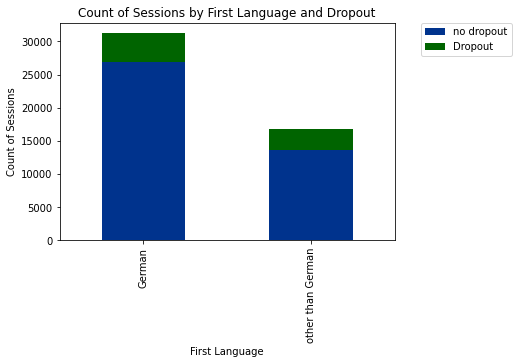

In [ ]:
data = {"Dropout": [4349, 3179], "no dropout": [26901, 13677]}

df = pd.DataFrame(
    data, columns=["no dropout", "Dropout"], index=["German", "other than German"]
)

ax = df.plot(kind="bar", stacked=True, color=["#00338d", "darkgreen"])
# Add Title and Labels
plt.title("Count of Sessions by First Language and Dropout")
plt.xlabel("First Language")
plt.ylabel("Count of Sessions")
plt.legend(bbox_to_anchor=(1.35, 1), loc="upper right", borderaxespad=0)

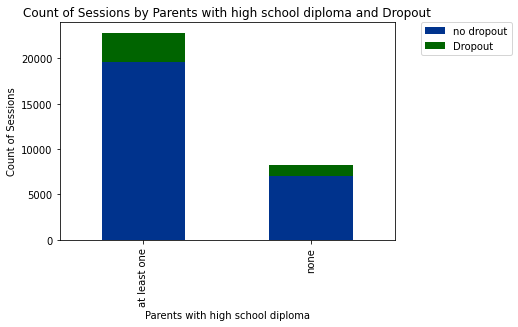

In [ ]:
data = {"Dropout": [3224, 1167], "no dropout": [19597, 7064]}

df = pd.DataFrame(
    data, columns=["no dropout", "Dropout"], index=["at least one", "none"]
)

ax = df.plot(kind="bar", stacked=True, color=["#00338d", "darkgreen"])
# Add Title and Labels
plt.title("Count of Sessions by Parents with high school diploma and Dropout")
plt.xlabel("Parents with high school diploma")
plt.ylabel("Count of Sessions")
plt.legend(bbox_to_anchor=(1.35, 1), loc="upper right", borderaxespad=0)

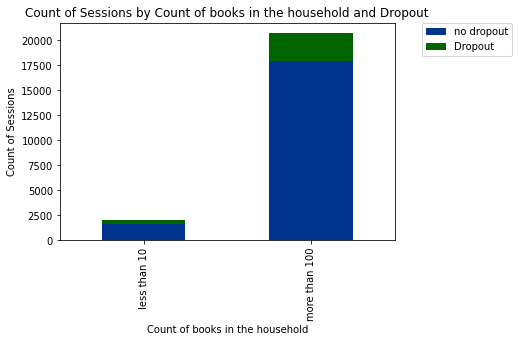

In [ ]:
data = {"Dropout": [406, 2756], "no dropout": [1653, 17955]}

df = pd.DataFrame(
    data, columns=["no dropout", "Dropout"], index=["less than 10", "more than 100"]
)

ax = df.plot(kind="bar", stacked=True, color=["#00338d", "darkgreen"])
# Add Title and Labels
plt.title("Count of Sessions by Count of books in the household and Dropout")
plt.xlabel("Count of books in the household")
plt.ylabel("Count of Sessions")
plt.legend(bbox_to_anchor=(1.35, 1), loc="upper right", borderaxespad=0)